<a href="https://colab.research.google.com/github/Fonseca-BrunoC/Processo-batelada---Monod/blob/main/Otimiza%C3%A7%C3%A3o_modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [154]:
#Importando as bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from scipy.integrate import odeint

In [155]:
mimax = 0.5 #unidade 1/hora - taxa específica de crescimento
Ks = 1.5 #constante de semi-saturação
Yxs = 0.5 #coeficiente estequiométrico
kd = 0.05 #constante de morte celular
alfa = 0.5 #constante do produto associado ao crescimento
beta = 0.2 #constante do produto não associado ao crescimento
t = np.linspace(0, 24, 500) #vetor tempo com t final de 24 horas

In [156]:
#Definindo as EDO's
#Essa função será utilizada tanto para estimar os parâmetros quanto para testa-los
def edo(C, t):
  mi = mimax * (C[1] / (Ks + C[1])) #Monod
  dCxdt = (mi - kd) * C[0] #eq para célula
  dCsdt = - (1/Yxs) * (mi - kd) * C[0] #eq para o substrato
  dCpdt = (alfa * mi)  * C[0] #eq do produto parcialmente associado ao crescimento
  return dCxdt, dCsdt, dCpdt

In [157]:
#Definindo a função resíduo que será aplicada na evolução diferencial
objetivo = 30
def rmse(I):
  CI = I[0], I[1], 0
  sim = odeint(edo, y0 = CI, t = t)
  P = sim[:,2]
  residuo = P[-1] - objetivo
  residuo = residuo ** 2
  return residuo

In [158]:
limites = [(0, 10),(0, 100)] #limites para cada um dos parâmetros 
result = []
n = 0
while n <= 25: #cada resultado da evolução diferencial gera combinações diferentes, sendo assim vamos gerar 25 combinações e escolher a de menor custo 
  ci = differential_evolution(rmse, limites, popsize=5,  tol=0.01, mutation=(0.5, 1), recombination=0.7, updating='immediate') #aplicando a evolução diferencial
  Ci = ci.x
  if Ci[0] > (Ci[1] / 2):
    n = n
  else:
    result.append(Ci)
    n = n + 1
matriz_result = np.array(result)

In [159]:
custo = np.array([])
for i in range(0,25):
  r = (matriz_result[i,0]*60) + (matriz_result[i,1]*20) #considerando o g/l de cx 60 reais e cs 20
  custo = np.append(custo, r)

min = np.min(custo)
lmin = np.where(custo == min)  
melhor_comb = matriz_result[lmin] 
#print(custo)
#print(min)
#print(lmin)
print(melhor_comb, min)

[[ 1.53204288 59.84906815]] 1288.9039356706242


In [160]:
#testando os resultados com uma simulação
def edo2(C, t):
  mi = mimax * (C[1] / (Ks + C[1])) #Monod
  dCxdt = (mi - kd) * C[0] #eq para célula
  dCsdt = - (1/Yxs) * (mi - kd) * C[0] #eq para o substrato
  dCpdt = (alfa * mi)  * C[0] #eq do produto parcialmente associado ao crescimento
  return dCxdt, dCsdt, dCpdt

In [161]:
ts = np.linspace(0, 24, 500) #vetor tempo em horas
Cis = (melhor_comb[0,0], melhor_comb[0,1], 0)
sol = odeint(edo, Cis, ts)

#Vetor com a concentração de células
Cx = sol[:,0]
#Vetor com a concentração de substrato
Cs = sol[:,1]
#Vetors com as concentrações de produto
Cp = sol[:,2]

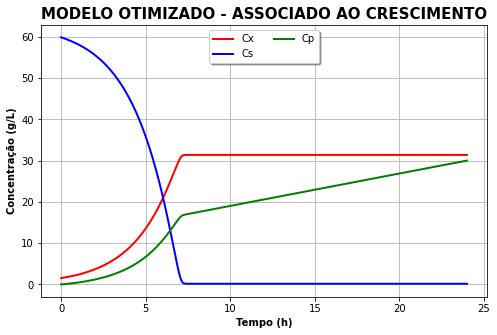

In [162]:
#Plotando o gráfico da simulação
f = plt.figure()     
ax = f.add_subplot(111)  
plt.rc('axes', titlesize=15)     
plt.rc('axes', labelsize=10)   
func = ax.plot(ts, Cx, 'r-', linewidth = 2, label ='Cx')
func2 = ax.plot(ts, Cs, 'b-', linewidth = 2, label= 'Cs')
func3 = ax.plot(ts, Cp, 'g-', linewidth = 2, label = 'Cp')
ax.set_title("MODELO OTIMIZADO - ASSOCIADO AO CRESCIMENTO", weight ='bold')  
ax.set_xlabel('Tempo (h)',weight='bold')               
ax.set_ylabel('Concentração (g/L)', weight='bold')
ax.grid(True)  
ax.legend(loc='upper center',ncol=2, shadow=True)
f.set_figheight(5)                                                 
f.set_figwidth(8)          
plt.show()